In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import constants as C
import pandas as pd

%matplotlib widget

In [2]:
c_0 = 0.001
n_0 = c_0 * 1e3 * C.N_A
n_ref = n_0 # C.C_WATER_BULK * 1e3 * C.N_A
kappa = np.sqrt(C.BETA * C.E_0**2 * n_ref / C.EPS_0 / C.EPS_R_WATER)

x_dl = 100 * 1e-9
# x_r = 1.61 * (1e-9) ** (1/3) * (8.91e-4/997) ** (1/6) * (2500*2*np.pi/60) ** (-1/2)

def ode_rhs(x, y):
    """
    y = [
        y1
        y2
        c_an_1
        c_an_2
        c_cat_1
        c_cat_2
    ]
    """
    dy1 = y[1, :]
    dy2 = y[2, :] - y[4, :]
    dy3 = y[3, :]
    dy4 =  y[3, :] * y[1, :] + y[2, :]*(y[2, :] - y[4, :])
    dy5 = y[5, :]
    dy6 = -y[5, :] * y[1, :] - y[4, :]*(y[2, :] - y[4, :])
    return np.vstack([dy1, dy2, dy3, dy4, dy5, dy6])

def current(nondim_efield):
    return 2 * np.exp(-1/2 * nondim_efield * kappa * C.D_ADSORBATE_LAYER)

def dirichlet_lambda(phi0): #pylint: disable=unused-argument
    """
    Return a boundary condition function to pass to scipy's solve_bvp
    """
    # old: return lambda ya, yb: np.array([ya[0] - C.BETA * C.Z * C.E_0 * phi0, yb[0]])
    return lambda ya, yb: np.array([
        ya[0] - C.BETA * C.E_0 * phi0 - ya[1] * kappa * C.D_ADSORBATE_LAYER, 
        ya[2]*ya[1] - ya[3] - current(ya[1]),
        -ya[4]*ya[1] - ya[5], 
        yb[0],
        yb[2] - n_0/n_ref,
        yb[4] - n_0/n_ref,
        # yb[0] + yb[1] * (x_r - x_dl) * kappa,
        # yb[2] + yb[3] * (x_r - x_dl) * kappa - n_0/n_ref,
        # yb[4] + yb[5] * (x_r - x_dl) * kappa - n_0/n_ref,
    ])

def create_x_mesh(xmax_nm, n_points):
    """
    Get a logarithmically spaced x-axis, fine mesh close to electrode
    """
    max_exponent = np.log10(xmax_nm)
    x_nm = np.logspace(-6, max_exponent, n_points) - 1e-6
    return kappa * 1e-9 * x_nm

def compute_profiles(sol) -> pd.DataFrame:
    result = pd.DataFrame({
        'x':  sol.x / kappa * 1e9,
        'phi':  sol.y[0, :] / (C.BETA * C.Z * C.E_0),
        'efield': -sol.y[1, :] * kappa / (C.BETA * C.Z * C.E_0),
        'cations': sol.y[4, :] * n_ref / 1e3 / C.N_A,
        'anions': sol.y[2, :] * n_ref / 1e3 / C.N_A,
        'eps': np.ones(sol.x.shape) * C.EPS_R_WATER})
    result.index.name = "Gouy-Chapman MT"
    return result

def potential_sequential_solve(potential: np.ndarray, tol: float=1e-3) -> list[pd.DataFrame]:
    df_list = []
    max_res = np.zeros(potential.shape)

    x_axis = create_x_mesh(x_dl * 1e9, 1000)
    y_initial = np.zeros((6, len(x_axis)))
    y_initial[2, :] = n_0/n_ref
    y_initial[4, :] = n_0/n_ref
    
    for i, phi in enumerate(potential):
        sol = solve_bvp(
            ode_rhs,
            dirichlet_lambda(phi),
            x_axis,
            y_initial,
            tol=tol,
            max_nodes=int(1e8),
            verbose=0)
        profile_df = compute_profiles(sol)
        max_res[i] = np.max(sol.rms_residuals)
        df_list.append(profile_df)

        x_axis = sol.x
        y_initial = sol.y

    print(f"Sweep from {potential[0]:.2f}V to {potential[-1]:.2f}V. " \
        + f"Maximum relative residual: {np.max(max_res):.5e}.")
    return df_list

def potential_sweep(potential: np.ndarray, tol: float=1e-3) -> pd.DataFrame:
    """
    Numerical solution to a potential sweep for a defined double-layer model.
    """
    # Find potential closest to PZC
    i_pzc = np.argmin(np.abs(potential)).squeeze()

    profiles_neg = potential_sequential_solve(potential[i_pzc::-1], tol=tol)
    profiles_pos = potential_sequential_solve(potential[i_pzc::1], tol=tol)

    all_profiles = profiles_neg[::-1] + profiles_pos[1:]

    # Create dataframe with interface values (iloc[0]) to return
    sweep_df = pd.concat(
        [pd.DataFrame(profile.iloc[0]).transpose() for profile in all_profiles],
        ignore_index=True)
    sweep_df.index.name = "Poisson-Nernst-Planck"

    sweep_df['phi0'] = potential
    sweep_df['charge'] = sweep_df['efield'] * C.EPS_0 * sweep_df['eps']
    if 'phi' in sweep_df.columns:
        sweep_df.rename({'phi': 'phi2'}, inplace=True, axis=1)
    if 'x' in sweep_df.columns:
        sweep_df.drop('x', inplace=True, axis=1)

    return sweep_df

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.82e+02       5.30e+03         1000           1998      
       2          6.22e-01       2.17e-01         2998           5088      
       3          3.31e-06       7.64e-07         8086             0       
Solved in 3 iterations, number of nodes 8086. 
Maximum relative residual: 3.31e-06 
Maximum boundary residual: 7.64e-07
Sweep from 0.00V to -0.10V. Maximum relative residual: 3.44942e-05.


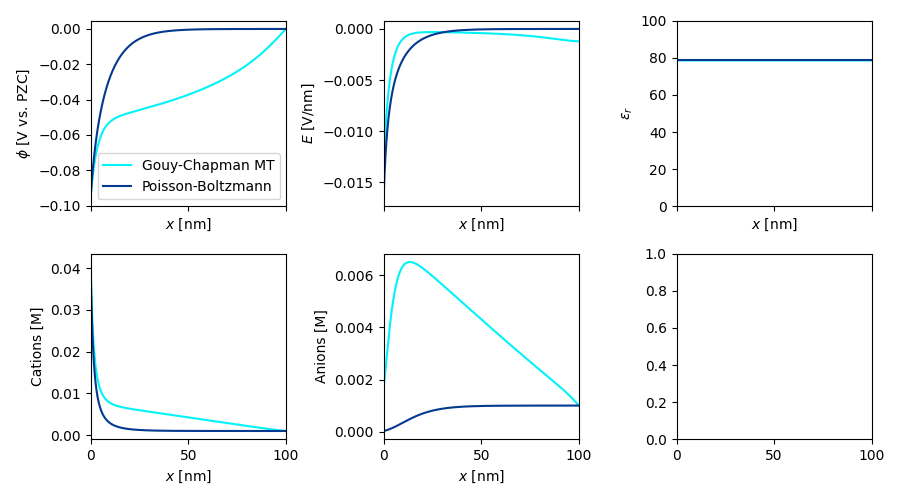

In [3]:
import edl
import plotting

phi0 = -0.1

# MT Gouy-Chapman
x_axis = create_x_mesh(x_dl * 1e9, 1000)
y_initial = np.zeros((6, len(x_axis)))
y_initial[2, :] = n_0/n_ref
y_initial[4, :] = n_0/n_ref
sol = solve_bvp(
                ode_rhs,
                dirichlet_lambda(phi0),
                x_axis,
                np.zeros((6, len(x_axis))),
                tol=1e-4,
                max_nodes=int(1e8),
                verbose=2)
gc_mt_sol = compute_profiles(sol)

# Old Gouy-Chapman
gc = edl.GouyChapman(c_0)
gc_sol = gc.spatial_profiles(phi0 - 0.01)
gc_sol.index.name = "Poisson-Boltzmann"

fig, ax = plotting.plot_solutions([gc_mt_sol, gc_sol], 0, x_dl*1e9)
plt.show()

In [4]:
potentials_v_pzc = np.linspace(-0.7, 0, 100)
sweep_sol = potential_sweep(potentials_v_pzc, tol=1e-3)
gc_sweep_sol = gc.potential_sweep(potentials_v_pzc, tol=1e-3)

Sweep from 0.00V to -0.70V. Maximum relative residual: 3.14284e-05.
Sweep from 0.00V to 0.00V. Maximum relative residual: 1.65437e-05.
Sweep from 0.00V to -0.70V. Maximum relative residual: 3.63766e-05.
Sweep from 0.00V to 0.00V. Maximum relative residual: 0.00000e+00.


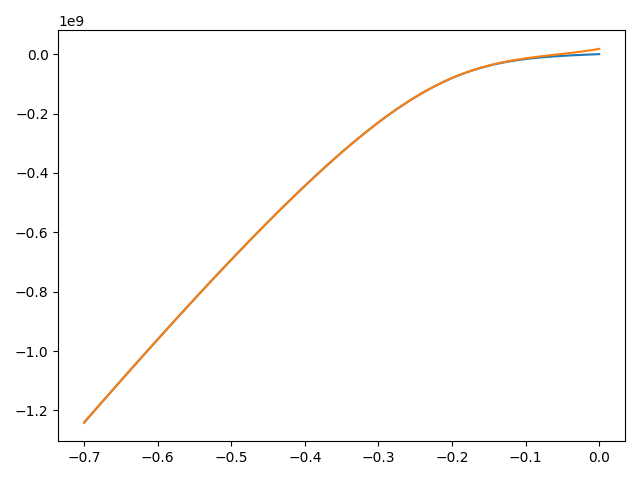

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
# ax.plot(sweep_sol['phi0'], -current(sweep_sol['efield'] * C.BETA * C.E_0 / kappa))
# ax.plot(gc_sweep_sol['phi0'], -current(gc_sweep_sol['efield'] * C.BETA * C.E_0 / kappa))
ax.plot(gc_sweep_sol['phi0'], gc_sweep_sol['efield'])
ax.plot(sweep_sol['phi0'], sweep_sol['efield'])
plt.tight_layout()

In [ ]:
ya = sol.y[:, 0]
yb = sol.y[:, -1]

In [ ]:
ya[0], - C.BETA * C.E_0 * phi0, ya[1] * kappa * C.D_ADSORBATE_LAYER

In [ ]:
ya[2]*ya[1], ya[3], current(ya[1])

In [ ]:
-ya[4]*ya[1], - ya[5]

In [ ]:
yb[0], + yb[1] * (x_r - x_dl) * kappa,

In [ ]:
yb[2], yb[3] * (x_r - x_dl) * kappa, n_0/n_ref

In [ ]:
yb[4], yb[5] * (x_r - x_dl) * kappa, n_0/n_ref,

In [ ]:
ya